In [1]:
from openimages.download import download_dataset
import os
import shutil
from sklearn.model_selection import train_test_split
import glob as glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [30]:
TRAIN = True
EPOCHS = 10

## Download and Split the Data

In [3]:
# select classes to be downloaded
class_names = ["Alpaca"]

# download the images and annotations for the specified classes
if __name__ == "__main__":
    download_dataset(dest_dir='data/', class_labels=class_names, annotation_format='darknet')

2024-07-02  09:52:52 INFO Downloading 94 train images for class 'alpaca'
100%|██████████| 94/94 [00:09<00:00, 10.14it/s]
2024-07-02  09:53:02 INFO Creating 94 train annotations (darknet) for class 'alpaca'
100%|██████████| 94/94 [00:01<00:00, 88.68it/s]
2024-07-02  09:53:05 INFO Downloading 14 validation images for class 'alpaca'
100%|██████████| 14/14 [00:04<00:00,  3.13it/s]
2024-07-02  09:53:10 INFO Creating 14 validation annotations (darknet) for class 'alpaca'
100%|██████████| 14/14 [00:01<00:00, 13.00it/s]
2024-07-02  09:53:16 INFO Downloading 34 test images for class 'alpaca'
100%|██████████| 34/34 [00:06<00:00,  5.50it/s]
2024-07-02  09:53:23 INFO Creating 34 test annotations (darknet) for class 'alpaca'
100%|██████████| 34/34 [00:01<00:00, 30.97it/s]


In [5]:
# define paths to images and labels
base_dir = 'data/alpaca'
images_dir = os.path.join(base_dir, 'images')
labels_dir = os.path.join(base_dir, 'labels')

# count the number of files in each directory
num_images = len([name for name in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, name))])
num_labels = len([name for name in os.listdir(labels_dir) if os.path.isfile(os.path.join(labels_dir, name))])

print(f"Number of images: {num_images}")
print(f"Number of labels: {num_labels}")

Number of images: 142
Number of labels: 142


In [6]:
# create subdirectories
subdirs = ['train', 'validation', 'test']
for subdir in subdirs:
    os.makedirs(os.path.join(images_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, subdir), exist_ok=True)

In [7]:
# set list of files
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

# sort the files to ensure matching
image_files.sort()
label_files.sort()

In [8]:
# split the data
train_images, temp_images, train_labels, temp_labels = train_test_split(image_files, label_files, test_size=48, random_state=42)
validation_images, test_images, validation_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=34, random_state=42)

In [12]:
# function to move files to respective directories
def move_files(file_list, src_dir, dest_dir):
    for file in file_list:
        shutil.move(os.path.join(src_dir, file), os.path.join(dest_dir, file))

In [13]:
# move the files to new directories
move_files(train_images, images_dir, os.path.join(images_dir, 'train'))
move_files(validation_images, images_dir, os.path.join(images_dir, 'validation'))
move_files(test_images, images_dir, os.path.join(images_dir, 'test'))

move_files(train_labels, labels_dir, os.path.join(labels_dir, 'train'))
move_files(validation_labels, labels_dir, os.path.join(labels_dir, 'validation'))
move_files(test_labels, labels_dir, os.path.join(labels_dir, 'test'))

## Data Exploration

In [14]:
def yolo_to_bbox(yolo_bbox, img_width, img_height):
    """
    Convert YOLO bounding box format to [xmin, ymin, width, height] format.
    """
    class_id, x_center, y_center, width, height = map(float, yolo_bbox.split())
    xmin = (x_center - width / 2) * img_width
    ymin = (y_center - height / 2) * img_height
    bbox_width = width * img_width
    bbox_height = height * img_height

    return class_id, xmin, ymin, bbox_width, bbox_height

In [15]:
def visualize_bounding_boxes(image_path, label_path):
    """
    Visualize bounding boxes on the image.
    """
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = image.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Read bounding box annotations
    with open(label_path, 'r') as f:
        bboxes = f.readlines()

    # Plot each bounding box
    for bbox in bboxes:
        class_id, xmin, ymin, bbox_width, bbox_height = yolo_to_bbox(bbox, img_width, img_height)
        rect = patches.Rectangle((xmin, ymin), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

In [16]:
def get_first_n_files(directory, n):
    """
    Get the first n files in the directory sorted by their names.
    """
    files = sorted([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
    return files[:n]

In [17]:
def process_files(image_dir, label_dir, n):
    """
    Process the first n files in the directory.
    """
    # get the first n files from the image and label directories
    image_files = get_first_n_files(image_dir, n)
    label_files = get_first_n_files(label_dir, n)

    # import images and labels and visualize
    for image_file, label_file in zip(image_files, label_files):
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, label_file)
        print(f"Processing {image_path} and {label_path}")
        visualize_bounding_boxes(image_path, label_path)

Processing data/alpaca/images/train/0346463867a297f4.jpg and data/alpaca/labels/train/0346463867a297f4.txt


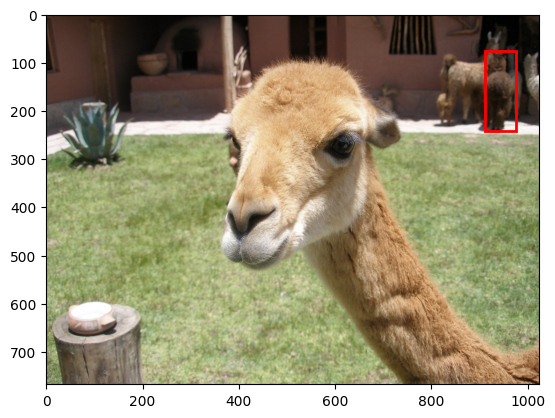

Processing data/alpaca/images/train/038fae9e70c4c3f1.jpg and data/alpaca/labels/train/038fae9e70c4c3f1.txt


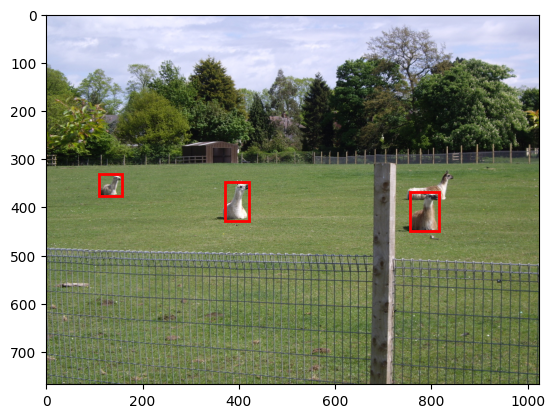

Processing data/alpaca/images/train/053608552d63f724.jpg and data/alpaca/labels/train/053608552d63f724.txt


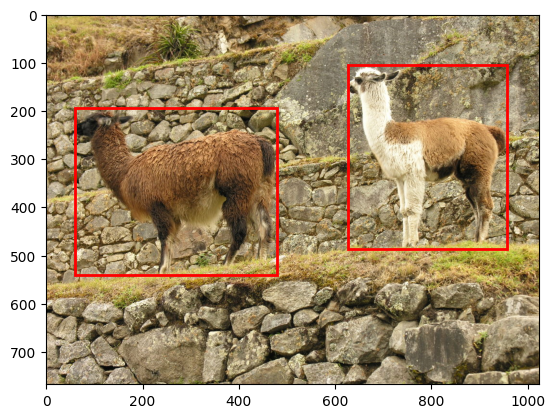

Processing data/alpaca/images/train/063a50c0a6408396.jpg and data/alpaca/labels/train/063a50c0a6408396.txt


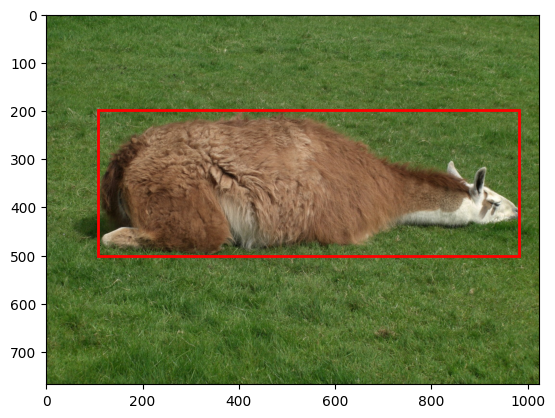

Processing data/alpaca/images/train/098cc30753a9cf13.jpg and data/alpaca/labels/train/098cc30753a9cf13.txt


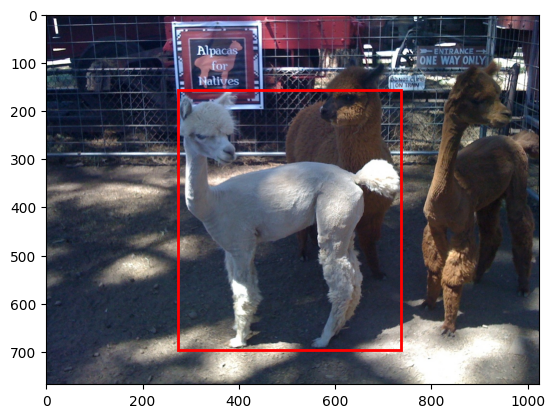

In [18]:
# select directories and number of images
image_dir = 'data/alpaca/images/train'
label_dir = 'data/alpaca/labels/train'
n = 5

# visualize
process_files(image_dir, label_dir, n)

## Helper Functions for Logging

In [25]:
def set_res_dir():
    # directory to store results
    res_dir_count = len(glob.glob('../runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"../results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"../results_{res_dir_count}"
    return RES_DIR

In [26]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir ../runs/train

## Clone YOLOv5 Repository

In [27]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16725, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 16725 (delta 138), reused 152 (delta 80), pack-reused 16459
Receiving objects: 100% (16725/16725), 15.39 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (11437/11437), done.


In [28]:
%cd yolov5/
!pwd

/Users/ivanosipchyk/dev/studies/yolo-fine-tuning/yolov5


In [29]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


## Training using YOLOv5

In [24]:
monitor_tensorboard()

Launching TensorBoard...

In [29]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 3
results_4
train: weights=yolov5s.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_4, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-334-g100a423b Python-3.10.11 torch-2.3.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05

## Check Validation Predictions and Inference

In [31]:
def show_val_results(RES_DIR):
    !ls ../runs/train/{RES_DIR}
    EXP_PATH = f"../runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [32]:
def inference(RES_DIR, data_path):
    infer_dir_count = len(glob.glob('../runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    !python detect.py --weights ../runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

In [33]:
def visualize(INFER_DIR):
    INFER_PATH = f"../runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

F1_curve.png
PR_curve.png
P_curve.png
R_curve.png
confusion_matrix.png
events.out.tfevents.1719834515.MacBook-Air-4.local.34954.0
hyp.yaml
labels.jpg
labels_correlogram.jpg
opt.yaml
results.csv
results.png
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
weights
['runs/train/results_4/val_batch0_pred.jpg']


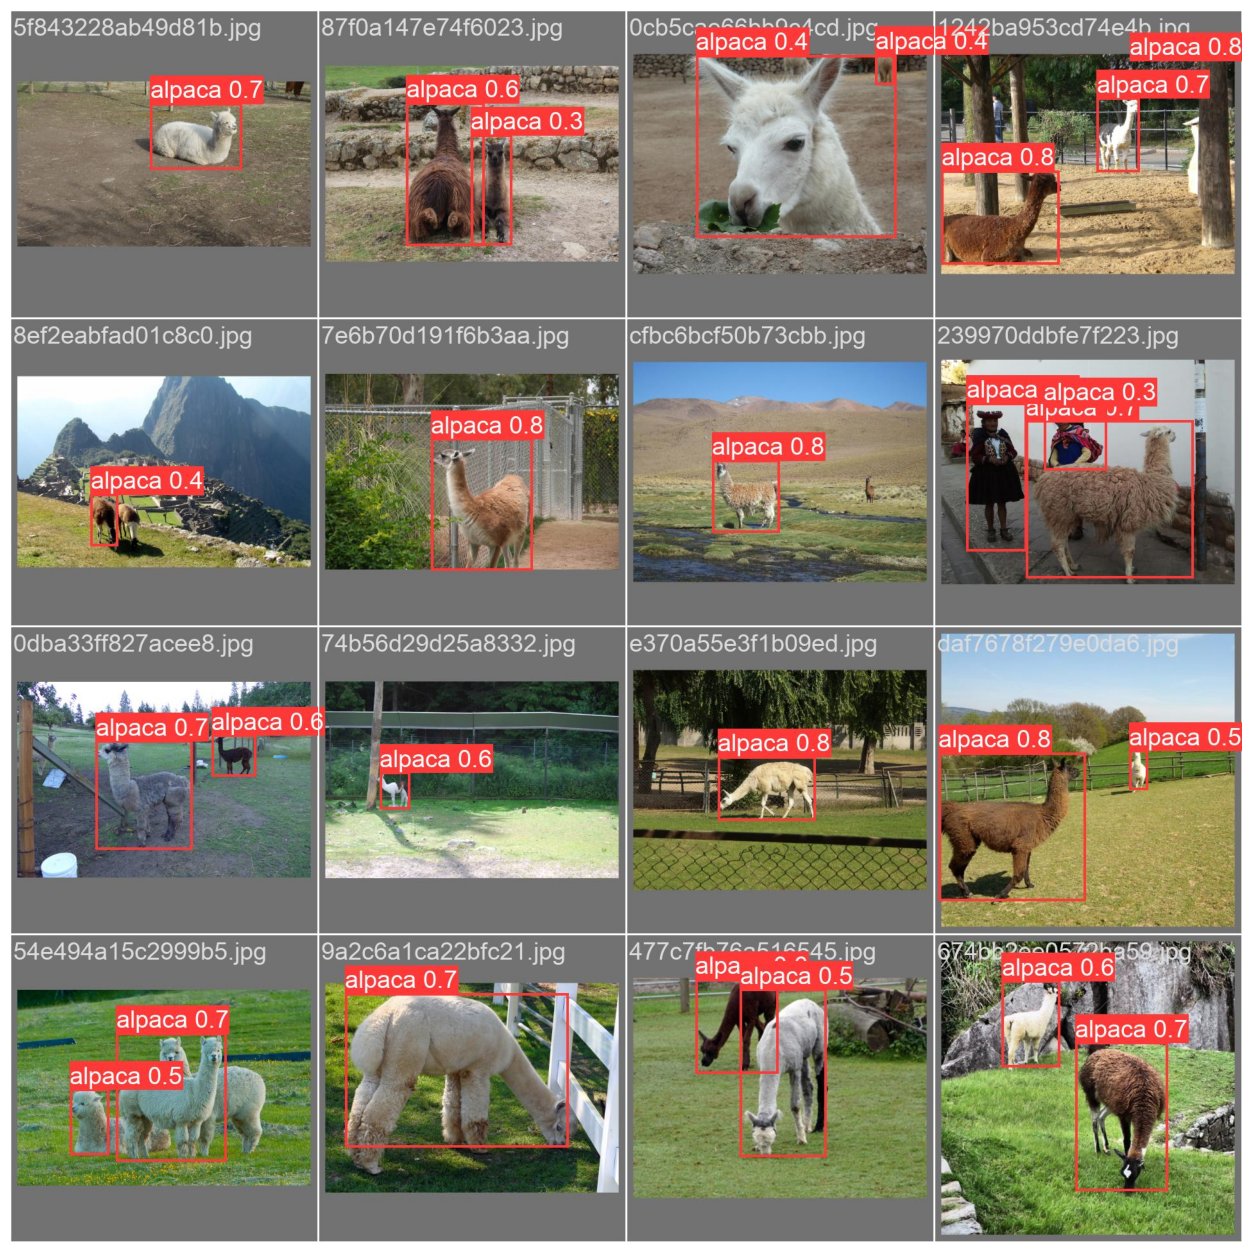

In [33]:
show_val_results(RES_DIR)

## Training Medium Model with Freezed Layers

In [34]:
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5m.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} \
    --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

train: weights=yolov5m.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_4, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-334-g100a423b Python-3.10.11 torch-2.3.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.0

F1_curve.png
PR_curve.png
P_curve.png
R_curve.png
confusion_matrix.png
events.out.tfevents.1719838568.MacBook-Air-4.local.46784.0
hyp.yaml
labels.jpg
labels_correlogram.jpg
opt.yaml
results.csv
results.png
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
weights
['runs/train/results_42/val_batch0_pred.jpg']


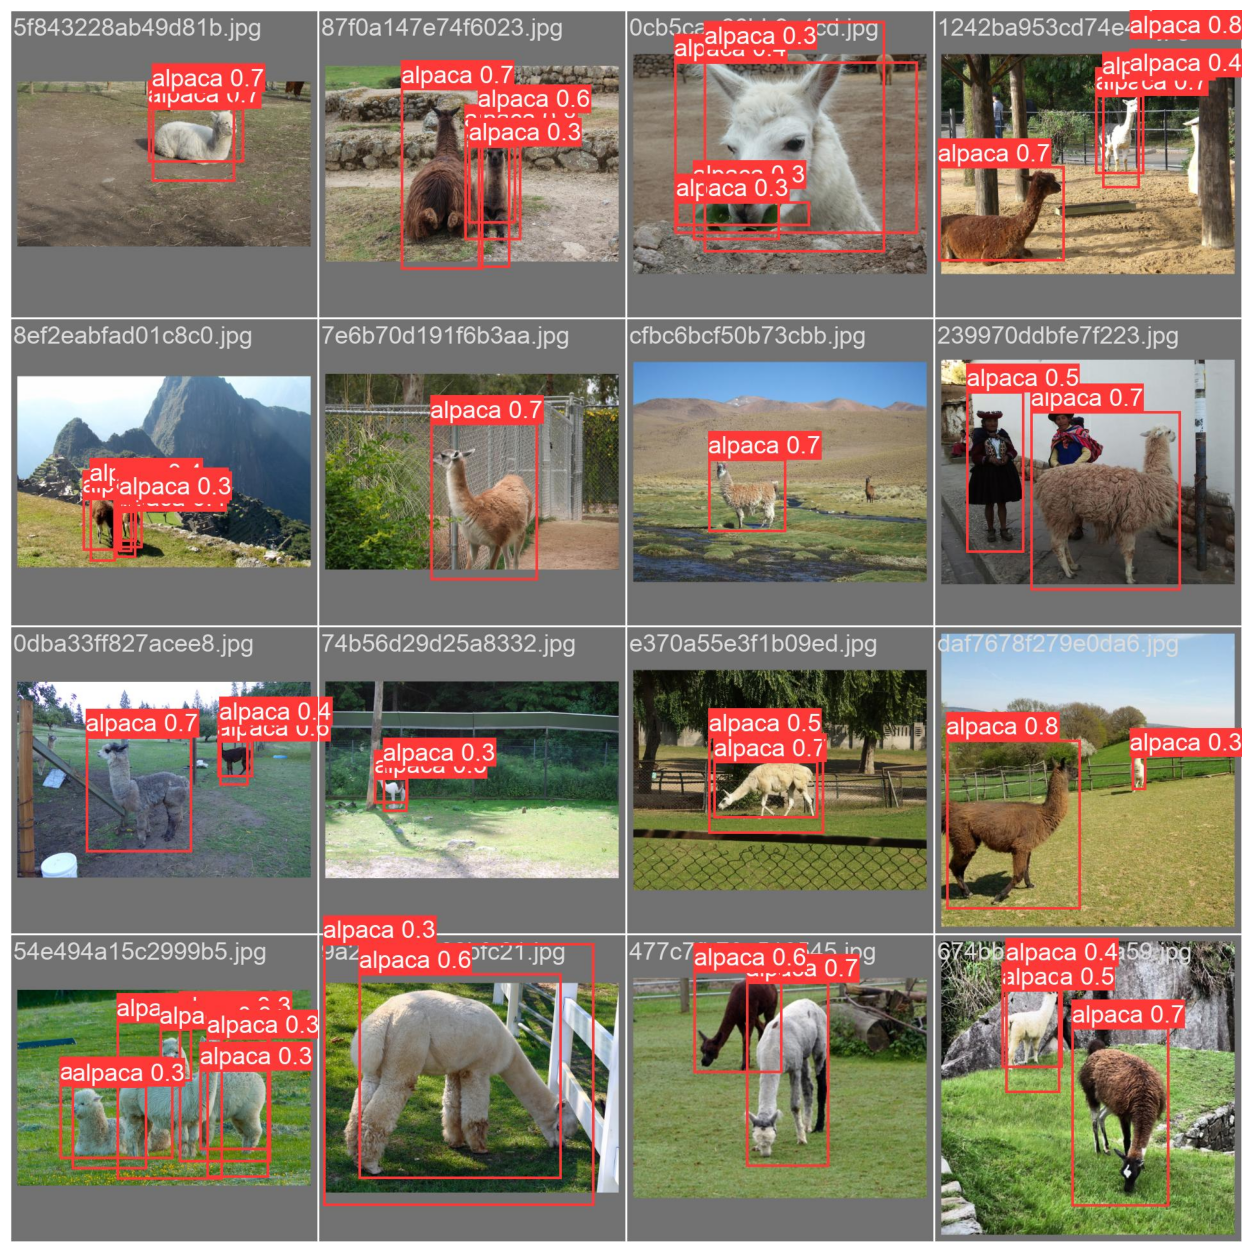

In [37]:
show_val_results("results_42")